In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [8]:
#!/usr/bin/env python3
"""
Unsupervised LSTM Autoencoder for STEAD Noise (Colab)
Time-series anomaly detection inside Z_channel waveforms
"""

import os
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split


# ============================================================
# CONFIGURATION
# ============================================================
DATA_PATH = "/content/drive/MyDrive/anomaly_selin/Data/df_noise_train.pkl"


LOOKBACK = 128
STRIDE = 64
BATCH_SIZE = 128        # ⬅️ GPU-friendly
EPOCHS = 50
MAX_TRACES = 4000
MAX_WINDOWS_PER_TRACE = 100
RANDOM_SEED = 42

MODEL_DIR = "/content/drive/MyDrive/anomaly_selin/models"
os.makedirs(MODEL_DIR, exist_ok=True)


# ============================================================
# LOAD DATA
# ============================================================
print("Loading STEAD noise data...")
df = pd.read_pickle(DATA_PATH)

df = df.sample(n=MAX_TRACES, random_state=RANDOM_SEED).reset_index(drop=True)
print(f"Loaded {len(df)} noise traces")


# ============================================================
# WINDOW EXTRACTION
# ============================================================
def make_windows(signal, win=128, stride=64):
    windows = []
    for i in range(0, len(signal) - win, stride):
        windows.append(signal[i:i + win])
    return np.array(windows, dtype=np.float32)


# ============================================================
# BUILD DATASET
# ============================================================
print("Building training windows...")

X_all = []

for z in df["Z_channel"]:
    z = np.asarray(z, dtype=np.float32)
    z = (z - z.mean()) / (z.std() + 1e-6)

    windows = make_windows(z, LOOKBACK, STRIDE)

    if len(windows) > MAX_WINDOWS_PER_TRACE:
        idx = np.random.choice(len(windows), MAX_WINDOWS_PER_TRACE, replace=False)
        windows = windows[idx]

    X_all.append(windows)

X = np.vstack(X_all)
X = X[..., np.newaxis]

print("Total windows:", X.shape[0])
print("Window shape :", X.shape[1:])


# ============================================================
# TRAIN / VALIDATION SPLIT
# ============================================================
X_train, X_val = train_test_split(
    X, test_size=0.2, random_state=RANDOM_SEED, shuffle=True
)

print("Train windows:", X_train.shape)
print("Val windows  :", X_val.shape)


# ============================================================
# LSTM AUTOENCODER
# ============================================================
print("Building LSTM Autoencoder...")

input_seq = Input(shape=(LOOKBACK, 1))

x = LSTM(64, return_sequences=True)(input_seq)
x = LSTM(32, return_sequences=False)(x)

x = RepeatVector(LOOKBACK)(x)

x = LSTM(32, return_sequences=True)(x)
x = LSTM(64, return_sequences=True)(x)

output_seq = TimeDistributed(Dense(1))(x)

model = Model(input_seq, output_seq)
model.compile(optimizer="adam", loss="mse")

model.summary()


# ============================================================
# CALLBACKS
# ============================================================
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "lstm_ae_best.keras"),
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)


# ============================================================
# TRAIN
# ============================================================
print("Starting training...")

history = model.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[early_stop, checkpoint]
)


# ============================================================
# SAVE FINAL MODEL
# ============================================================
final_model_path = os.path.join(MODEL_DIR, "lstm_ae_final.keras")
model.save(final_model_path)

print("\nTraining complete.")
print(f"Best model saved to : {MODEL_DIR}/lstm_ae_best.keras")
print(f"Final model saved to: {final_model_path}")


Loading STEAD noise data...
Loaded 4000 noise traces
Building training windows...
Total windows: 368000
Window shape : (128, 1)
Train windows: (294400, 128, 1)
Val windows  : (73600, 128, 1)
Building LSTM Autoencoder...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 128, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,529 (244.25 KB)

 Trainable params: 62,529 (244.25 KB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/50
2299/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8743
Epoch 1: val_loss improved from inf to 0.76869, saving model to /content/drive/MyDrive/anomaly_selin/models/lstm_ae_best.keras
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 93s 37ms/step - loss: 0.8742 - val_loss: 0.7687
Epoch 2/50
2299/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7460
Epoch 2: val_loss improved from 0.76869 to 0.71616, saving model to /content/drive/MyDrive/anomaly_selin/models/lstm_ae_best.keras
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - loss: 0.7459 - val_loss: 0.7162
Epoch 3/50
2299/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7032
Epoch 3: val_loss improved from 0.71616 to 0.71351, saving model to /content/drive/MyDrive/anomaly_selin/models/lstm_ae_best.keras
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - loss: 0.7032 - val_loss: 0.7135
Epoch 4/50
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6933
Epoch 4: val_loss improved from 0.71351 to 0.68292, saving model to /cont

In [9]:
#!/usr/bin/env python3
"""
Evaluate trained LSTM Autoencoder on TRAIN NOISE data
Purpose:
- Compute reconstruction error
- Derive anomaly threshold
- Sanity check model behavior
"""

import os
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import load_model


# ============================================================
# CONFIGURATION
# ============================================================
DATA_PATH = "/content/drive/MyDrive/anomaly_selin/Data/df_noise_train.pkl"
MODEL_PATH = "/content/drive/MyDrive/anomaly_selin/models/lstm_ae_best.keras"

LOOKBACK = 128
STRIDE = 64
MAX_TRACES = 2000
MAX_WINDOWS_PER_TRACE = 100
RANDOM_SEED = 42

# ============================================================
# LOAD MODEL
# ============================================================
print("🔹 Loading trained LSTM Autoencoder...")
model = load_model(MODEL_PATH)
print("✅ Model loaded")

# ============================================================
# LOAD TRAIN NOISE DATA
# ============================================================
print("\n🔹 Loading train noise data...")
df = pd.read_pickle(DATA_PATH)
df = df.sample(n=MAX_TRACES, random_state=RANDOM_SEED).reset_index(drop=True)
print(f"Loaded {len(df)} noise traces")

# ============================================================
# WINDOW FUNCTION
# ============================================================
def make_windows(signal, win=128, stride=64):
    windows = []
    for i in range(0, len(signal) - win, stride):
        windows.append(signal[i:i + win])
    return np.array(windows, dtype=np.float32)

# ============================================================
# BUILD WINDOWS
# ============================================================
print("\n🔹 Building windows from train noise...")

X_all = []

for z in df["Z_channel"]:
    z = np.asarray(z, dtype=np.float32)
    z = (z - z.mean()) / (z.std() + 1e-6)

    windows = make_windows(z, LOOKBACK, STRIDE)

    if len(windows) > MAX_WINDOWS_PER_TRACE:
        idx = np.random.choice(len(windows), MAX_WINDOWS_PER_TRACE, replace=False)
        windows = windows[idx]

    X_all.append(windows)

X = np.vstack(X_all)
X = X[..., np.newaxis]

print("Total windows:", X.shape[0])
print("Window shape :", X.shape[1:])

# ============================================================
# RECONSTRUCTION
# ============================================================
print("\n🔹 Running reconstruction...")
X_pred = model.predict(X, batch_size=256, verbose=1)

# ============================================================
# RECONSTRUCTION ERROR
# ============================================================
mse = np.mean((X - X_pred) ** 2, axis=(1, 2))

print("\n📊 TRAIN NOISE RECONSTRUCTION ERROR")
print("-" * 60)
print(f"Mean   : {mse.mean():.6f}")
print(f"Median : {np.median(mse):.6f}")
print(f"Std    : {mse.std():.6f}")

thr_95 = np.percentile(mse, 95)
thr_99 = np.percentile(mse, 99)

print("\n🎯 THRESHOLDS")
print("-" * 60)
print(f"95th percentile : {thr_95:.6f}")
print(f"99th percentile : {thr_99:.6f}")

# ============================================================
# SAVE THRESHOLD
# ============================================================
np.save("/content/drive/MyDrive/anomaly_selin/models/train_threshold_95.npy", thr_95)
np.save("/content/drive/MyDrive/anomaly_selin/models/train_threshold_99.npy", thr_99)

print("\n✅ Thresholds saved to Drive")
print("Evaluation on train noise complete.")


🔹 Loading trained LSTM Autoencoder...
✅ Model loaded

🔹 Loading train noise data...
Loaded 2000 noise traces

🔹 Building windows from train noise...
Total windows: 184000
Window shape : (128, 1)

🔹 Running reconstruction...
719/719 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step

📊 TRAIN NOISE RECONSTRUCTION ERROR
------------------------------------------------------------
Mean   : 0.416114
Median : 0.307730
Std    : 0.563892

🎯 THRESHOLDS
------------------------------------------------------------
95th percentile : 1.071591
99th percentile : 2.118489

✅ Thresholds saved to Drive
Evaluation on train noise complete.


In [12]:
import numpy as np
import os

# ============================================================
# PATH
# ============================================================
SAVE_PATH = "/content/drive/MyDrive/anomaly_selin/models/train_thresholds.npz"

# ============================================================
# THESE COME FROM YOUR TRAIN NOISE EVALUATION
# (replace with your actual numbers if needed)
# ============================================================
p95 = 1.071591
p99 = 2.118489

# ============================================================
# SAVE
# ============================================================
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

np.savez(
    SAVE_PATH,
    p95=p95,
    p99=p99
)

print("✅ Thresholds saved")
print(f"95th percentile : {p95}")
print(f"99th percentile : {p99}")
print(f"Saved to        : {SAVE_PATH}")


✅ Thresholds saved
95th percentile : 1.071591
99th percentile : 2.118489
Saved to        : /content/drive/MyDrive/anomaly_selin/models/train_thresholds.npz


🔹 Loading trained LSTM Autoencoder...
✅ Model loaded

🎯 Loaded thresholds from train noise
95th percentile : 1.0716
99th percentile : 2.1185

🔹 Loading earthquake test data...
Loaded 6000 earthquake traces

🔹 Building windows from earthquake traces...
Total windows: 552000
Window shape : (128, 1)

🔹 Running reconstruction...
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step

📊 EARTHQUAKE RECONSTRUCTION ERROR
------------------------------------------------------------
Mean   : 0.304227
Median : 0.025986
Std    : 1.109238

🚨 DETECTION RATE (EARTHQUAKE ONLY)
------------------------------------------------------------
> 95% threshold : 6.38%
> 99% threshold : 2.95%


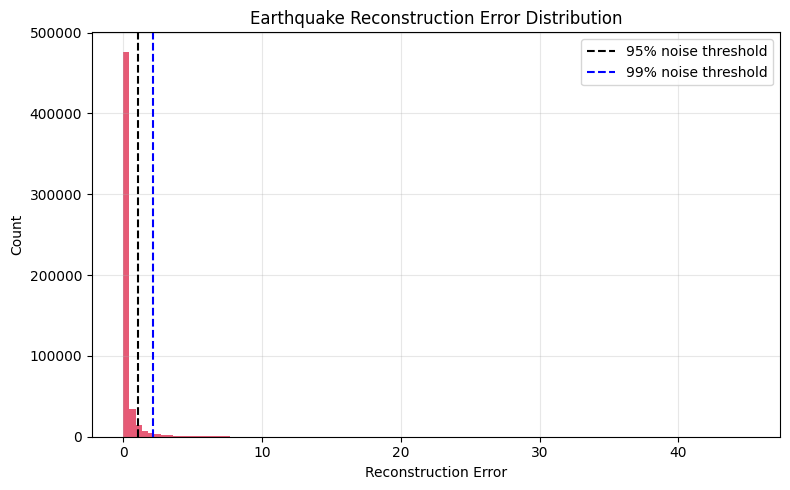


✅ Earthquake-only evaluation complete.


In [18]:
#!/usr/bin/env python3
"""
Earthquake-only Evaluation for LSTM Autoencoder (STEAD)

- Uses thresholds learned from TRAIN NOISE
- Evaluates detection rate on EARTHQUAKE data
- No ROC (single-class test set)
"""

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


# ============================================================
# CONFIG
# ============================================================
MODEL_PATH = "/content/drive/MyDrive/anomaly_selin/models/lstm_ae_best.keras"
THRESHOLD_PATH = "/content/drive/MyDrive/anomaly_selin/models/train_thresholds.npz"

TEST_DATA_PATH = "/content/drive/MyDrive/anomaly_selin/Data/df_test.pkl"

LOOKBACK = 128
STRIDE = 64
MAX_WINDOWS_PER_TRACE = 100


# ============================================================
# LOAD MODEL
# ============================================================
print("🔹 Loading trained LSTM Autoencoder...")
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded")


# ============================================================
# LOAD THRESHOLDS
# ============================================================
thr = np.load(THRESHOLD_PATH)
THR_95 = thr["p95"]
THR_99 = thr["p99"]

print("\n🎯 Loaded thresholds from train noise")
print(f"95th percentile : {THR_95:.4f}")
print(f"99th percentile : {THR_99:.4f}")


# ============================================================
# LOAD EARTHQUAKE TEST DATA
# ============================================================
print("\n🔹 Loading earthquake test data...")
df = pd.read_pickle(TEST_DATA_PATH)
print(f"Loaded {len(df)} earthquake traces")


# ============================================================
# WINDOW EXTRACTION
# ============================================================
def make_windows(signal, win=128, stride=64):
    windows = []
    for i in range(0, len(signal) - win, stride):
        windows.append(signal[i:i + win])
    return np.array(windows, dtype=np.float32)


# ============================================================
# BUILD TEST WINDOWS
# ============================================================
print("\n🔹 Building windows from earthquake traces...")

X_all = []

for z in df["Z_channel"]:
    z = np.asarray(z, dtype=np.float32)

    # SAME normalization as training
    z = (z - z.mean()) / (z.std() + 1e-6)

    windows = make_windows(z, LOOKBACK, STRIDE)

    if len(windows) > MAX_WINDOWS_PER_TRACE:
        idx = np.random.choice(len(windows), MAX_WINDOWS_PER_TRACE, replace=False)
        windows = windows[idx]

    X_all.append(windows)

X = np.vstack(X_all)
X = X[..., np.newaxis]

print("Total windows:", X.shape[0])
print("Window shape :", X.shape[1:])


# ============================================================
# RECONSTRUCTION
# ============================================================
print("\n🔹 Running reconstruction...")
X_hat = model.predict(X, batch_size=256)

recon_error = np.mean((X - X_hat) ** 2, axis=(1, 2))


# ============================================================
# EARTHQUAKE-ONLY EVALUATION
# ============================================================
print("\n📊 EARTHQUAKE RECONSTRUCTION ERROR")
print("------------------------------------------------------------")
print(f"Mean   : {np.mean(recon_error):.6f}")
print(f"Median : {np.median(recon_error):.6f}")
print(f"Std    : {np.std(recon_error):.6f}")

det_95 = np.mean(recon_error > THR_95)
det_99 = np.mean(recon_error > THR_99)

print("\n🚨 DETECTION RATE (EARTHQUAKE ONLY)")
print("------------------------------------------------------------")
print(f"> 95% threshold : {det_95 * 100:.2f}%")
print(f"> 99% threshold : {det_99 * 100:.2f}%")


# ============================================================
# HISTOGRAM PLOT
# ============================================================
plt.figure(figsize=(8, 5))
plt.hist(recon_error, bins=100, alpha=0.7, color="crimson")
plt.axvline(THR_95, color="black", linestyle="--", label="95% noise threshold")
plt.axvline(THR_99, color="blue", linestyle="--", label="99% noise threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.title("Earthquake Reconstruction Error Distribution")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


print("\n✅ Earthquake-only evaluation complete.")


🔹 Loading trained LSTM Autoencoder...
✅ Model loaded

🔹 Loading earthquake test data...
Loaded 2000 earthquake traces

🔹 Building labeled windows...
Total windows : 54324
Noise windows : 24681
EQ windows    : 29643

🔹 Running reconstruction...
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

📊 ROC AUC
------------------------------------------------------------
AUC : 0.9586

✅ Custom test dataset saved to:
/content/drive/MyDrive/anomaly_selin/Data/custom_window_test.npz
   Windows: (54324, 128, 1)
   Labels : (54324,)


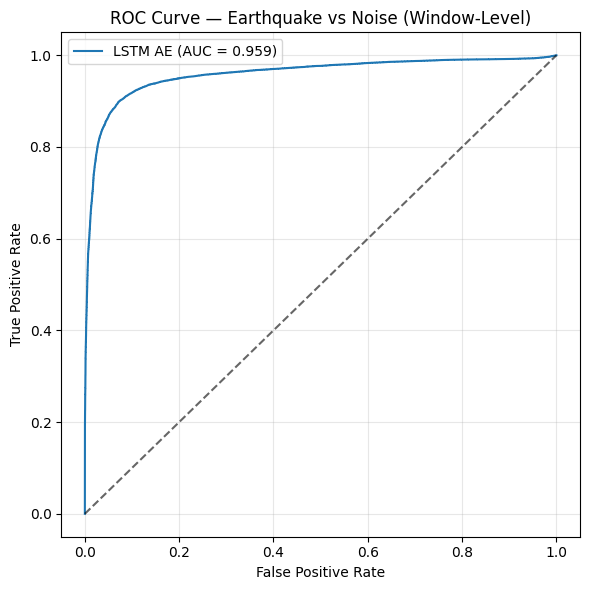

In [7]:
#!/usr/bin/env python3
"""
Window-level Earthquake Evaluation for LSTM Autoencoder
- Builds labeled windows from earthquake traces
- Labels:
    0 = pre-event noise
    1 = seismic (P/S region)
- Computes ROC + AUC
"""

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc


# ============================================================
# CONFIG
# ============================================================
MODEL_PATH = "/content/drive/MyDrive/anomaly_selin/models/lstm_ae_best.keras"
TEST_DATA_PATH = "/content/drive/MyDrive/anomaly_selin/Data/df_test.pkl"

LOOKBACK = 128
STRIDE = 64
MARGIN_SEC = 1.0              # seconds around P/S
SAMPLING_RATE = 100           # Hz
MARGIN = int(MARGIN_SEC * SAMPLING_RATE)

MAX_TRACES = 2000             # safety limit


# ============================================================
# LOAD MODEL
# ============================================================
print("🔹 Loading trained LSTM Autoencoder...")
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded")


# ============================================================
# LOAD TEST DATA
# ============================================================
print("\n🔹 Loading earthquake test data...")
df = pd.read_pickle(TEST_DATA_PATH)
df = df.sample(n=min(MAX_TRACES, len(df)), random_state=42).reset_index(drop=True)

print(f"Loaded {len(df)} earthquake traces")


# ============================================================
# WINDOW FUNCTION
# ============================================================
def make_windows(signal, win=128, stride=64):
    windows = []
    centers = []
    for i in range(0, len(signal) - win, stride):
        windows.append(signal[i:i + win])
        centers.append(i + win // 2)
    return np.array(windows, dtype=np.float32), np.array(centers)


# ============================================================
# BUILD LABELED TEST SET
# ============================================================
print("\n🔹 Building labeled windows...")

X_all = []
y_all = []

for _, row in df.iterrows():

    z = np.asarray(row["Z_channel"], dtype=np.float32)
    z = (z - z.mean()) / (z.std() + 1e-6)

    p = row["p_arrival_sample"]
    s = row["s_arrival_sample"]

    if np.isnan(p) or np.isnan(s):
        continue

    windows, centers = make_windows(z, LOOKBACK, STRIDE)

    for w, c in zip(windows, centers):

        # Label logic
        if c < (p - MARGIN):
            label = 0   # noise
        elif (p - MARGIN) <= c <= (s + MARGIN):
            label = 1   # earthquake
        else:
            continue    # ignore coda / aftershock region

        X_all.append(w)
        y_all.append(label)

X = np.array(X_all)[..., np.newaxis]
y = np.array(y_all)

print(f"Total windows : {len(X)}")
print(f"Noise windows : {(y == 0).sum()}")
print(f"EQ windows    : {(y == 1).sum()}")


# ============================================================
# RECONSTRUCTION ERROR
# ============================================================
print("\n🔹 Running reconstruction...")
X_hat = model.predict(X, batch_size=256, verbose=1)

errors = np.mean((X - X_hat) ** 2, axis=(1, 2))


# ============================================================
# ROC + AUC
# ============================================================
fpr, tpr, thresholds = roc_curve(y, errors)
roc_auc = auc(fpr, tpr)

print("\n📊 ROC AUC")
print("------------------------------------------------------------")
print(f"AUC : {roc_auc:.4f}")



SAVE_PATH = "/content/drive/MyDrive/anomaly_selin/Data/custom_window_test.npz"

np.savez_compressed(
    SAVE_PATH,
    X=X,
    y=y
)

print(f"\n✅ Custom test dataset saved to:\n{SAVE_PATH}")
print(f"   Windows: {X.shape}")
print(f"   Labels : {y.shape}")
# ============================================================
# PLOT
# ============================================================
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"LSTM AE (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Earthquake vs Noise (Window-Level)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



🔹 Loading trained LSTM Autoencoder...
✅ Model loaded

🔹 Loading test dataset...
✅ Dataset loaded
   Total windows: 54324
   Noise windows: 24681
   EQ windows: 29643

🔹 Computing reconstruction errors...
✅ Reconstruction complete
   Mean error: 0.542727
   Std error: 1.797430

🔹 Computing ROC curve...
✅ ROC AUC: 0.9586

🎯 OPTIMAL THRESHOLD SELECTION

1️⃣  YOUDEN'S J STATISTIC (TPR - FPR)
   Optimal threshold: 0.03091496
   TPR: 0.899
   FPR: 0.072
   J-score: 0.827

2️⃣  CLOSEST TO TOP-LEFT CORNER (0,1)
   Optimal threshold: 0.02886517
   TPR: 0.902
   FPR: 0.076
   Distance: 0.124

3️⃣  F1-SCORE MAXIMIZATION
   Optimal threshold: 0.03010513
   TPR: 0.900
   FPR: 0.074
   F1-Score: 0.912

📊 PERFORMANCE WITH YOUDEN'S OPTIMAL THRESHOLD

   Threshold: 0.03091496

   Confusion Matrix:
   ┌─────────────┬──────────┬──────────┐
   │             │ Pred: 0  │ Pred: 1  │
   ├─────────────┼──────────┼──────────┤
   │ True: 0     │    22905 │     1776 │
   │ True: 1     │     2997 │    26646 │
   

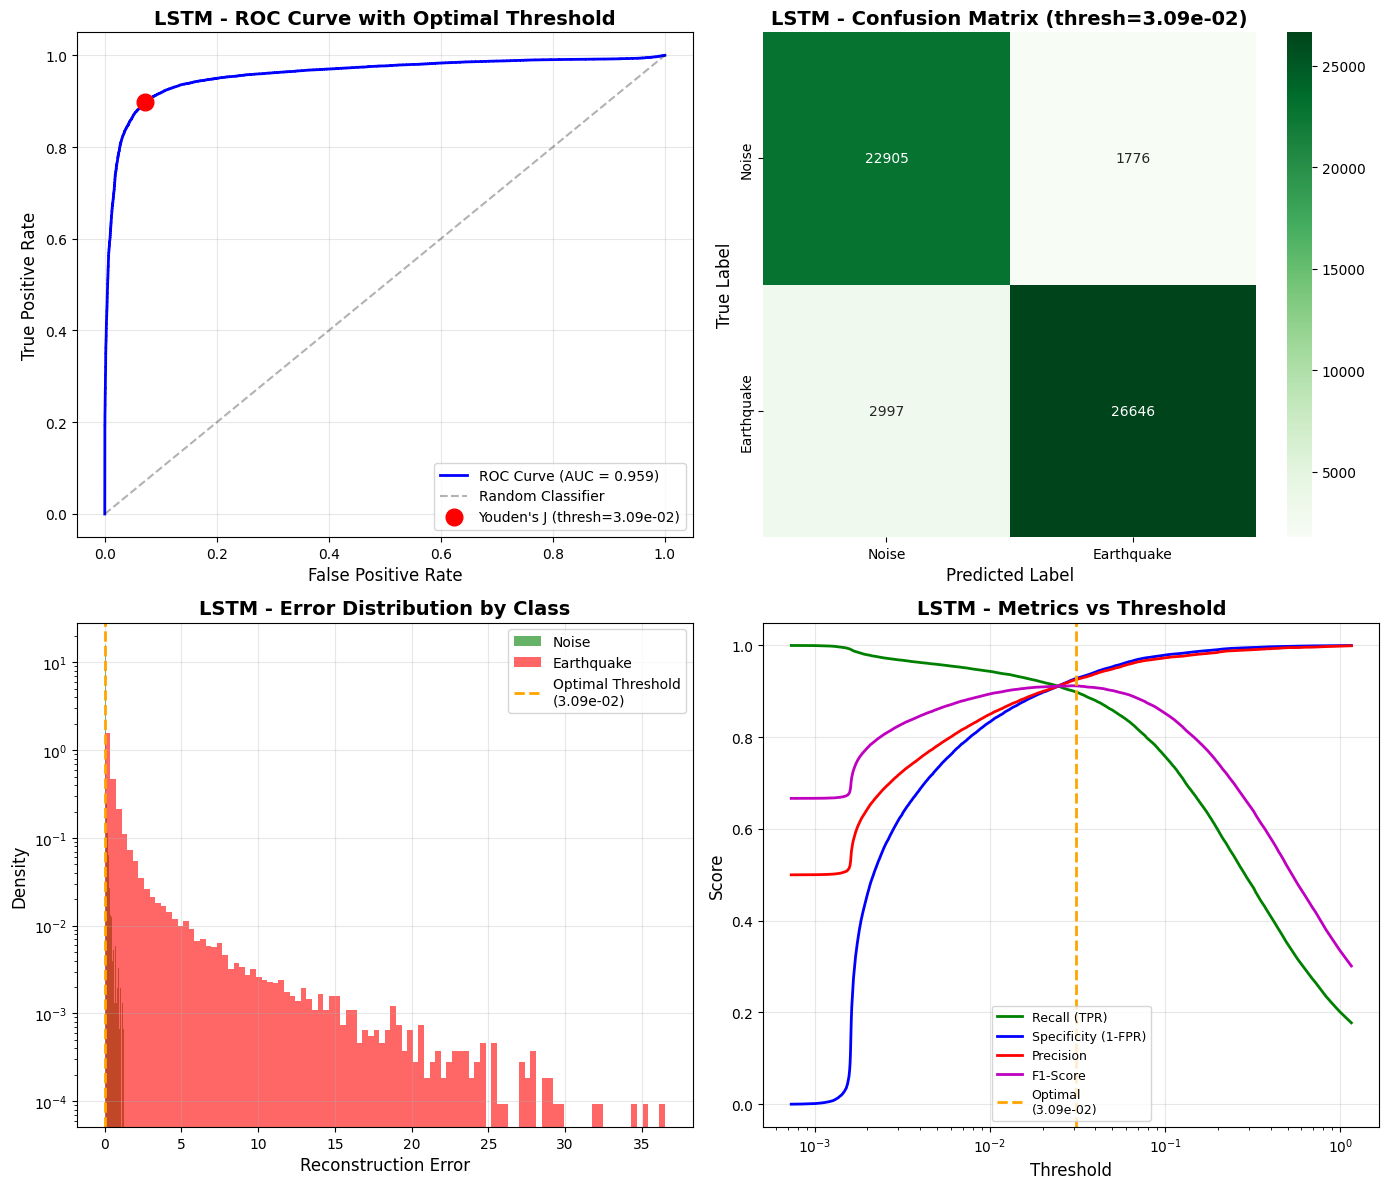


📈 THRESHOLD COMPARISON TABLE

Method          Threshold    Recall   Precision  F1       Accuracy
----------------------------------------------------------------------
p90             0.020848     0.918    0.917      0.918    0.910   
p95             0.046315     0.866    0.954      0.908    0.904   
p97             0.070410     0.816    0.970      0.887    0.886   
p99             0.187890     0.615    0.987      0.758    0.785   
Youden          0.030915     0.899    0.938      0.918    0.912   
Corner          0.028865     0.902    0.934      0.918    0.912   
F1-Max          0.030105     0.900    0.936      0.918    0.912   
✅ LSTM ROC-based threshold analysis complete!


In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# =========================
# PATHS
# =========================
MODEL_PATH = "./lstm_ae_best.keras"
TEST_NPZ   = "/Users/selinbardakci/BitirmeProjesi/data/custom_window_test.npz"

# =========================
# LOAD MODEL
# =========================
print("🔹 Loading trained LSTM Autoencoder...")
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded\n")

# =========================
# LOAD TEST DATA
# =========================
print("🔹 Loading test dataset...")
data = np.load(TEST_NPZ)
X = data["X"]   # (N, 128, 1)
y = data["y"]   # (N,)

print(f"✅ Dataset loaded")
print(f"   Total windows: {len(X)}")
print(f"   Noise windows: {(y==0).sum()}")
print(f"   EQ windows: {(y==1).sum()}\n")

# =========================
# COMPUTE RECONSTRUCTION ERROR
# =========================
print("🔹 Computing reconstruction errors...")
X_hat = model.predict(X, batch_size=256, verbose=0)
errors = np.mean((X - X_hat) ** 2, axis=(1, 2))

print(f"✅ Reconstruction complete")
print(f"   Mean error: {errors.mean():.6f}")
print(f"   Std error: {errors.std():.6f}\n")

# =========================
# ROC CURVE
# =========================
print("🔹 Computing ROC curve...")
fpr, tpr, thresholds = roc_curve(y, errors)
roc_auc = auc(fpr, tpr)

print(f"✅ ROC AUC: {roc_auc:.4f}\n")

# =========================
# OPTIMAL THRESHOLD METHODS
# =========================
print("="*70)
print("🎯 OPTIMAL THRESHOLD SELECTION")
print("="*70)

# Method 1: Youden's J statistic (maximize TPR - FPR)
j_scores = tpr - fpr
optimal_idx_youden = np.argmax(j_scores)
optimal_threshold_youden = thresholds[optimal_idx_youden]

print(f"\n1️⃣  YOUDEN'S J STATISTIC (TPR - FPR)")
print(f"   Optimal threshold: {optimal_threshold_youden:.8f}")
print(f"   TPR: {tpr[optimal_idx_youden]:.3f}")
print(f"   FPR: {fpr[optimal_idx_youden]:.3f}")
print(f"   J-score: {j_scores[optimal_idx_youden]:.3f}")

# Method 2: Closest to top-left corner (0,1)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
optimal_idx_corner = np.argmin(distances)
optimal_threshold_corner = thresholds[optimal_idx_corner]

print(f"\n2️⃣  CLOSEST TO TOP-LEFT CORNER (0,1)")
print(f"   Optimal threshold: {optimal_threshold_corner:.8f}")
print(f"   TPR: {tpr[optimal_idx_corner]:.3f}")
print(f"   FPR: {fpr[optimal_idx_corner]:.3f}")
print(f"   Distance: {distances[optimal_idx_corner]:.3f}")

# Method 3: F1-Score maximization
precisions = tpr / (tpr + fpr + 1e-10)
f1_scores = 2 * (precisions * tpr) / (precisions + tpr + 1e-10)
optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds[optimal_idx_f1]

print(f"\n3️⃣  F1-SCORE MAXIMIZATION")
print(f"   Optimal threshold: {optimal_threshold_f1:.8f}")
print(f"   TPR: {tpr[optimal_idx_f1]:.3f}")
print(f"   FPR: {fpr[optimal_idx_f1]:.3f}")
print(f"   F1-Score: {f1_scores[optimal_idx_f1]:.3f}")

# =========================
# EVALUATE WITH YOUDEN'S THRESHOLD (RECOMMENDED)
# =========================
OPTIMAL_THRESHOLD = optimal_threshold_youden
y_pred = (errors > OPTIMAL_THRESHOLD).astype(int)

cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp + 1e-9)
recall = tp / (tp + fn + 1e-9)
f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
specificity = tn / (tn + fp + 1e-9)

print("\n" + "="*70)
print("📊 PERFORMANCE WITH YOUDEN'S OPTIMAL THRESHOLD")
print("="*70)
print(f"\n   Threshold: {OPTIMAL_THRESHOLD:.8f}")
print(f"\n   Confusion Matrix:")
print(f"   ┌─────────────┬──────────┬──────────┐")
print(f"   │             │ Pred: 0  │ Pred: 1  │")
print(f"   ├─────────────┼──────────┼──────────┤")
print(f"   │ True: 0     │ {tn:8d} │ {fp:8d} │")
print(f"   │ True: 1     │ {fn:8d} │ {tp:8d} │")
print(f"   └─────────────┴──────────┴──────────┘")
print(f"\n   Metrics:")
print(f"   • Accuracy:    {accuracy:.3f}")
print(f"   • Precision:   {precision:.3f}")
print(f"   • Recall:      {recall:.3f}")
print(f"   • F1-Score:    {f1:.3f}")
print(f"   • Specificity: {specificity:.3f}")
print(f"   • ROC AUC:     {roc_auc:.3f}")

# =========================
# VISUALIZATIONS
# =========================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. ROC Curve with optimal point
ax1 = axes[0, 0]
ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random Classifier')
ax1.plot(fpr[optimal_idx_youden], tpr[optimal_idx_youden], 'ro', 
         markersize=12, label=f"Youden's J (thresh={optimal_threshold_youden:.2e})")
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('LSTM - ROC Curve with Optimal Threshold', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# 2. Confusion Matrix Heatmap
ax2 = axes[0, 1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=True, ax=ax2,
            xticklabels=['Noise', 'Earthquake'],
            yticklabels=['Noise', 'Earthquake'])
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_title(f'LSTM - Confusion Matrix (thresh={OPTIMAL_THRESHOLD:.2e})', 
              fontsize=14, fontweight='bold')

# 3. Error Distribution with Threshold
ax3 = axes[1, 0]
noise_errors = errors[y == 0]
eq_errors = errors[y == 1]

ax3.hist(noise_errors, bins=100, alpha=0.6, color='green', label='Noise', density=True)
ax3.hist(eq_errors, bins=100, alpha=0.6, color='red', label='Earthquake', density=True)
ax3.axvline(OPTIMAL_THRESHOLD, color='orange', linestyle='--', linewidth=2, 
            label=f'Optimal Threshold\n({OPTIMAL_THRESHOLD:.2e})')
ax3.set_xlabel('Reconstruction Error', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('LSTM - Error Distribution by Class', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.set_yscale('log')

# 4. Metrics vs Threshold
ax4 = axes[1, 1]
sample_indices = np.linspace(0, len(thresholds)-1, 1000, dtype=int)
ax4.plot(thresholds[sample_indices], tpr[sample_indices], 'g-', label='Recall (TPR)', linewidth=2)
ax4.plot(thresholds[sample_indices], 1-fpr[sample_indices], 'b-', label='Specificity (1-FPR)', linewidth=2)
ax4.plot(thresholds[sample_indices], precisions[sample_indices], 'r-', label='Precision', linewidth=2)
ax4.plot(thresholds[sample_indices], f1_scores[sample_indices], 'm-', label='F1-Score', linewidth=2)
ax4.axvline(OPTIMAL_THRESHOLD, color='orange', linestyle='--', linewidth=2, 
            label=f'Optimal\n({OPTIMAL_THRESHOLD:.2e})')
ax4.set_xlabel('Threshold', fontsize=12)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('LSTM - Metrics vs Threshold', fontsize=14, fontweight='bold')
ax4.set_xscale('log')
ax4.legend(loc='best', fontsize=9)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# =========================
# COMPARISON TABLE
# =========================
print("\n" + "="*70)
print("📈 THRESHOLD COMPARISON TABLE")
print("="*70)

comparison_thresholds = {
    "p90": np.percentile(noise_errors, 90),
    "p95": np.percentile(noise_errors, 95),
    "p97": np.percentile(noise_errors, 97),
    "p99": np.percentile(noise_errors, 99),
    "Youden": optimal_threshold_youden,
    "Corner": optimal_threshold_corner,
    "F1-Max": optimal_threshold_f1
}

print(f"\n{'Method':<15} {'Threshold':<12} {'Recall':<8} {'Precision':<10} {'F1':<8} {'Accuracy':<8}")
print("-" * 70)

for name, thresh in comparison_thresholds.items():
    y_p = (errors > thresh).astype(int)
    cm_temp = confusion_matrix(y, y_p)
    tn_t, fp_t, fn_t, tp_t = cm_temp.ravel()
    
    acc = (tp_t + tn_t) / (tp_t + tn_t + fp_t + fn_t)
    prec = tp_t / (tp_t + fp_t + 1e-9)
    rec = tp_t / (tp_t + fn_t + 1e-9)
    f1_t = 2 * (prec * rec) / (prec + rec + 1e-9)
    
    print(f"{name:<15} {thresh:<12.6f} {rec:<8.3f} {prec:<10.3f} {f1_t:<8.3f} {acc:<8.3f}")

print("="*70)
print("✅ LSTM ROC-based threshold analysis complete!")
print("="*70)

In [2]:
from sklearn.metrics import precision_recall_curve, matthews_corrcoef, confusion_matrix
import numpy as np

print("\n🔧 Adding advanced thresholding methods (NumPy-only)...\n")

advanced_thresholds = {}

# ============================================================
# 0) BASIC NOISE SUBSET
# ============================================================
noise_errors = errors[y == 0]


# ============================================================
# 1) PR-F1 MAX THRESHOLD
# ============================================================
precisions_pr, recalls_pr, th_pr = precision_recall_curve(y, errors)
f1_pr = 2 * (precisions_pr * recalls_pr) / (precisions_pr + recalls_pr + 1e-9)
idx_f1_pr = np.argmax(f1_pr)
th_pr_f1 = th_pr[idx_f1_pr]
advanced_thresholds["PR-F1-Max"] = th_pr_f1


# ============================================================
# 2) MCC-MAX THRESHOLD
# ============================================================
best_mcc = -1
best_th_mcc = None

for th in thresholds:
    y_pred = (errors > th).astype(int)
    mcc = matthews_corrcoef(y, y_pred)
    if mcc > best_mcc:
        best_mcc = mcc
        best_th_mcc = th

advanced_thresholds["MCC-Max"] = best_th_mcc


# ============================================================
# 3) G-MEAN MAX THRESHOLD
# ============================================================
gmean = np.sqrt(tpr * (1 - fpr))
idx_gmean = np.argmax(gmean)
th_gmean = thresholds[idx_gmean]
advanced_thresholds["G-Mean-Max"] = th_gmean


# ============================================================
# 4) PRECISION ≥ 0.95 Threshold (maximize recall)
# ============================================================
best_rec = -1
best_th_prec95 = None

for th in thresholds:
    y_pred = (errors > th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    precision_curr = tp / (tp + fp + 1e-9)
    recall_curr = tp / (tp + fn + 1e-9)

    if precision_curr >= 0.95 and recall_curr > best_rec:
        best_rec = recall_curr
        best_th_prec95 = th

advanced_thresholds["Prec≥0.95"] = best_th_prec95


# ============================================================
# 5) k-SIGMA THRESHOLD (Noise-only)
# ============================================================
mu = noise_errors.mean()
sigma = noise_errors.std()
k = 4.0   # changeable
th_ksigma = mu + k * sigma
advanced_thresholds["kSigma(k=4)"] = th_ksigma


# ============================================================
# 6) MAD THRESHOLD (Noise-only)
# ============================================================
median = np.median(noise_errors)
mad = np.median(np.abs(noise_errors - median))
k_mad = 6.0
th_mad = median + k_mad * mad
advanced_thresholds["MAD(k=6)"] = th_mad


# ============================================================
# 7) NUMPY-ONLY KMEANS (2 clusters)
# ============================================================
def kmeans_1d_threshold(errors, max_iter=100):
    e = errors.reshape(-1, 1).astype(float)

    # initialize cluster centers at min and max
    c1 = np.min(e)
    c2 = np.max(e)

    for _ in range(max_iter):
        # assign clusters
        labels = np.where(np.abs(e - c1) < np.abs(e - c2), 0, 1)

        new_c1 = np.mean(e[labels == 0])
        new_c2 = np.mean(e[labels == 1])

        # break on convergence
        if np.isclose(c1, new_c1) and np.isclose(c2, new_c2):
            break

        c1, c2 = new_c1, new_c2

    centers = np.sort([c1, c2])
    return (centers[0] + centers[1]) / 2.0

th_kmeans = kmeans_1d_threshold(errors)
advanced_thresholds["KMeans"] = th_kmeans


# ============================================================
# 8) NUMPY-ONLY OTSU THRESHOLD
# ============================================================
def otsu_threshold(errs):
    errs = np.sort(errs)
    hist, bin_edges = np.histogram(errs, bins=256)
    hist = hist.astype(float)

    # normalized histogram
    p = hist / np.sum(hist)
    omega = np.cumsum(p)
    mu = np.cumsum(p * np.arange(256))
    mu_t = mu[-1]

    sigma_b = (mu_t * omega - mu)**2 / (omega * (1 - omega) + 1e-9)
    idx = np.argmax(sigma_b)
    return bin_edges[idx]

th_otsu = otsu_threshold(errors)
advanced_thresholds["Otsu"] = th_otsu


# ============================================================
# MERGE WITH ORIGINAL TABLE
# ============================================================
comparison_thresholds.update(advanced_thresholds)


# ============================================================
# PRINT EXTENDED TABLE
# ============================================================
print("\n" + "="*70)
print("📈 EXTENDED THRESHOLD COMPARISON TABLE")
print("="*70)
print(f"\n{'Method':<15} {'Threshold':<12} {'Recall':<8} {'Precision':<10} {'F1':<8} {'Accuracy':<8}")
print("-" * 70)

for name, thresh in comparison_thresholds.items():
    y_p = (errors > thresh).astype(int)
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(y, y_p).ravel()
    
    acc = (tp_t + tn_t) / (tp_t + tn_t + fp_t + fn_t)
    prec = tp_t / (tp_t + fp_t + 1e-9)
    rec = tp_t / (tp_t + fn_t + 1e-9)
    f1_t = 2 * (prec * rec) / (prec + rec + 1e-9)
    
    print(f"{name:<15} {thresh:<12.6f} {rec:<8.3f} {prec:<10.3f} {f1_t:<8.3f} {acc:<8.3f}")

print("="*70)
print("✅ NumPy-only advanced threshold analysis complete!")
print("="*70)



🔧 Adding advanced thresholding methods (NumPy-only)...


📈 EXTENDED THRESHOLD COMPARISON TABLE

Method          Threshold    Recall   Precision  F1       Accuracy
----------------------------------------------------------------------
p90             0.020848     0.918    0.917      0.918    0.910   
p95             0.046315     0.866    0.954      0.908    0.904   
p97             0.070410     0.816    0.970      0.887    0.886   
p99             0.187890     0.615    0.987      0.758    0.785   
Youden          0.030915     0.899    0.938      0.918    0.912   
Corner          0.028865     0.902    0.934      0.918    0.912   
F1-Max          0.030105     0.900    0.936      0.918    0.912   
PR-F1-Max       0.025148     0.910    0.927      0.918    0.912   
MCC-Max         0.030914     0.899    0.938      0.918    0.912   
G-Mean-Max      0.030915     0.899    0.938      0.918    0.912   
Prec≥0.95       0.041493     0.877    0.950      0.912    0.908   
kSigma(k=4)     0.250844    